In [1]:
import time
import pickle
import numpy as np
import networkx as nx
import queue
import glob
import matplotlib.pyplot as plt

from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection
import itertools
from scipy.optimize import minimize

from cutqc.main import CutQC
from qiskit import *
from qiskit.circuit import Qubit
from qiskit.circuit.library.standard_gates import XGate
from qiskit.circuit import ControlledGate
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_histogram
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler import PassManager

import qsplit_circuit_cutter as qcc
import qsplit_mlrecon_methods as qmm

import dqva

from utils.graph_funcs import *
from utils.helper_funcs import *

In [2]:
def get_cut_solution(cutqc, max_subcirc_qubit):
    circname = list(cutqc.circuits.keys())[0]
    subcirc_file = 'cutqc_data/' + circname + '/cc_{}/subcircuits.pckl'.format(max_subcirc_qubit)
    picklefile = open(subcirc_file, 'rb')
    cut_solution = pickle.load(picklefile)
    return cut_solution

def cut_and_print(circ, max_subcircuit_qubit, num_subcircuits, max_cuts):
    circuits = {'my_circ':circ}
    cutqc = CutQC(circuits=circuits, max_subcircuit_qubit=max_subcircuit_qubit,
                  num_subcircuits=num_subcircuits, max_cuts=max_cuts, verbose=1)
    cutsoln = get_cut_solution(cutqc, max_subcircuit_qubit)
    print('Complete Path Map:')
    
    wpm = {}
    for key in cutsoln['complete_path_map']:
        print(key, '->', cutsoln['complete_path_map'][key])
        temp = []
        for frag_qubit in cutsoln['complete_path_map'][key]:
            temp.append((frag_qubit['subcircuit_idx'], frag_qubit['subcircuit_qubit']))
        wpm[key] = tuple(temp)
        
    print('positions:', cutsoln['positions'])
    for i, sc in enumerate(cutsoln['subcircuits']):
        print('Subcirc', i)
        print('\tqubits = {}, gate counts = {}'.format(len(sc.qubits), sc.count_ops()))
        print(sc.draw(fold=200))
    
    return cutsoln['subcircuits'], wpm

In [14]:
def fidelity(dist, actual_dist):
    fidelity = sum( np.sqrt(actual_dist[bits] * dist[bits], dtype = complex)
                    for bits in all_bits
                    if actual_dist.get(bits) and dist.get(bits) )**2
    return fidelity.real if fidelity.imag == 0 else fidelity

def naive_fix(dist):
    norm = sum( value for value in dist.values() if value >= 0 )
    return { bits : value / norm for bits, value in dist.items() if value >= 0 }

## Start with a simple example
The goal is to convert the cutQC `complete_path_map` to the QSPLIT `wire_path_map`

In [4]:
nq = 3
ghz_circ = QuantumCircuit(nq, name='q')
for i in range(nq):
    ghz_circ.rz(i, i)
ghz_circ.h(0)
for i in range(nq-1):
    ghz_circ.cx(i, i+1)
for i in range(nq):
    ghz_circ.rz(i, i)
ghz_circ.draw(fold=-1)

┌───────┐┌───┐     ┌───────┐         
q_0: ┤ RZ(0) ├┤ H ├──■──┤ RZ(0) ├─────────
     ├───────┤└───┘┌─┴─┐└───────┘┌───────┐
q_1: ┤ RZ(1) ├─────┤ X ├────■────┤ RZ(1) ├
     ├───────┤     └───┘  ┌─┴─┐  ├───────┤
q_2: ┤ RZ(2) ├────────────┤ X ├──┤ RZ(2) ├
     └───────┘            └───┘  └───────┘

In [5]:
subcircs, wpm = cut_and_print(ghz_circ, 2, [2], 1)

-------------------- Cut --------------------
Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only
my_circ : 1 cuts --> {0: {'effective': 1, 'rho': 0, 'O': 1, 'd': 2}, 1: {'effective': 2, 'rho': 1, 'O': 0, 'd': 2}}
Complete Path Map:
Qubit(QuantumRegister(3, 'q'), 0) -> [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 0)}]
Qubit(QuantumRegister(3, 'q'), 1) -> [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 1)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 0)}]
Qubit(QuantumRegister(3, 'q'), 2) -> [{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 1)}]
positions: [(Qubit(QuantumRegister(3, 'q'), 1), 1)]
Subcirc 0
	qubits = 2, gate counts = OrderedDict([('rz', 3), ('h', 1), ('cx', 1)])
     ┌───────┐┌───┐     ┌───────┐
q_0: ┤ RZ(0) ├┤ H ├──■──┤ RZ(0) ├
     ├───────┤└───┘┌─┴─┐└───────┘
q_1: ┤ RZ(1) ├─────┤ X ├─────────
     └───────┘     └───┘       

In [6]:
print(subcircs)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f97cc0f2690>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f97cc0f2410>]


In [7]:
print(wpm)

{Qubit(QuantumRegister(3, 'q'), 0): ((0, Qubit(QuantumRegister(2, 'q'), 0)),), Qubit(QuantumRegister(3, 'q'), 1): ((0, Qubit(QuantumRegister(2, 'q'), 1)), (1, Qubit(QuantumRegister(2, 'q'), 0))), Qubit(QuantumRegister(3, 'q'), 2): ((1, Qubit(QuantumRegister(2, 'q'), 1)),)}


In [8]:
shots = 999999
total_variants = 7
simulation_backend = 'qasm_simulator'
frag_data = qmm.collect_fragment_data(subcircs, wpm, shots=shots // total_variants,
                                      tomography_backend=simulation_backend)
direct_models = qmm.direct_fragment_model(frag_data)
likely_models = qmm.maximum_likelihood_model(direct_models)

direct_recombined_dist = qmm.recombine_fragment_models(direct_models, wpm)
likely_recombined_dist = qmm.recombine_fragment_models(likely_models, wpm)

/Users/teague/anaconda3/envs/cutEnv/lib/python3.7/site-packages/qiskit/ignis/verification/tomography/basis/sicbasis.py:48: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  circ.u3(theta, np.pi, 0.0, qubit)


In [9]:
direct_recombined_dist = naive_fix(direct_recombined_dist)

In [10]:
all_bits = [ "".join(bits) for bits in itertools.product(["0", "1"], repeat = nq) ]

actual_state = qmm.get_statevector(ghz_circ)
actual_dist = { "".join(bits) : abs(amp)**2 for bits, amp in zip(all_bits, actual_state) if amp != 0 }

In [11]:
direct_fidelity = fidelity(direct_recombined_dist, actual_dist)
likely_fidelity = fidelity(likely_recombined_dist, actual_dist)

In [12]:
print("actual probability distribution:")
for bits in all_bits:
    try: print(bits, actual_dist[bits])
    except : None

print()
print("'direct' recombined probability distribution:")
for bits in all_bits:
    try: print(bits, direct_recombined_dist[bits])
    except : None

print()
print("'likely' recombined probability distribution:")
for bits in all_bits:
    try: print(bits, likely_recombined_dist[bits])
    except : None

print()
print("'direct' distribution fidelity:", direct_fidelity)
print("'likely' distribution fidelity:", likely_fidelity)

actual probability distribution:
000 0.5000000000000001
111 0.4999999999999999

'direct' recombined probability distribution:
000 0.499737253082761
001 0.00039776518837233846
110 0.001209497863989891
111 0.4986554838648769

'likely' recombined probability distribution:
000 0.49932793416339805
001 0.0016187972455698806
110 0.0008044614044321837
111 0.4982488071866001

'direct' distribution fidelity: 0.9983924439204199
'likely' distribution fidelity: 0.9975764495139606


### NOTE:
The QSPLIT-MLFT adds a small amount of noise to the circuit execution. This can be accounted for within the DQVA algorithm by postprocessing the 
resulting bitstrings and checking that they are valid MIS

## Cut, evalutate, and reconstruct a DQV Ansatz

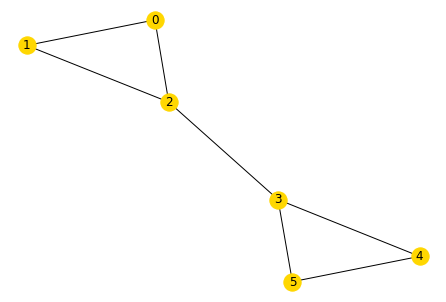

In [2]:
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (3, 5), (4,5)])
nx.draw_spring(G, with_labels=True, node_color='gold')
nq = len(G.nodes())

In [3]:
kl_bisection = ({3, 4, 5}, {0, 1, 2})
params = list(range(1, 2*nq+1+1))
print(params)
cur_init_state = '0'*nq
cur_permutation = list(range(nq))
dqv_circ = dqva.gen_dqva(G, kl_bisection, params=params, init_state=cur_init_state, cut=True,
                         mixer_order=cur_permutation, verbose=1, decompose_toffoli=0,
                         barriers=2, hot_nodes=[2])
print(dqv_circ.count_ops())
dqv_circ.draw(fold=-1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Current partition: ({3, 4, 5}, {0, 1, 2})
subgraphs: [[3, 4, 5], [0, 1, 2]]
cutedges: [(2, 3)]
hot nodes: [2]
alpha_1: [1, 2, 3, 4, 5, 6]
gamma_1: 7
alpha_2: [8, 9, 10, 11, 12, 13]
Qubit 3 is cold! Apply Identity mixer
qubit: 4 num_qubits = 8 neighbors: [3, 5]
qubit: 5 num_qubits = 8 neighbors: [3, 4]
qubit: 0 num_qubits = 8 neighbors: [1, 2]
qubit: 1 num_qubits = 8 neighbors: [0, 2]
qubit: 2 num_qubits = 8 neighbors: [0, 1, 3]
Qubit 3 is cold! Apply Identity mixer
qubit: 4 num_qubits = 8 neighbors: [3, 5]
qubit: 5 num_qubits = 8 neighbors: [3, 4]
qubit: 0 num_qubits = 8 neighbors: [1, 2]
qubit: 1 num_qubits = 8 neighbors: [0, 2]
Qubit 2 is cold! Apply Identity mixer
OrderedDict([('mc_toffoli', 18), ('barrier', 12), ('crx', 9), ('rz', 6)])


░                      ░                      ░      ┌───────┐      ░                     ░                     ░  ░ ┌────────┐ ░                      ░                      ░      ┌────────┐      ░                      ░ 
  q_0: ─░──────────────────────░──────────────────────░──────┤ RX(2) ├──────░───o─────────────o───░───o─────────────o───░──░─┤ RZ(14) ├─░──────────────────────░──────────────────────░──────┤ RX(16) ├──────░───o──────────────o───░─
        ░                      ░                      ░      └───┬───┘      ░   │  ┌───────┐  │   ░   │             │   ░  ░ ├────────┤ ░                      ░                      ░      └───┬────┘      ░   │  ┌────────┐  │   ░ 
  q_1: ─░──────────────────────░──────────────────────░───o──────┼──────o───░───┼──┤ RX(4) ├──┼───░───o─────────────o───░──░─┤ RZ(14) ├─░──────────────────────░──────────────────────░───o──────┼───────o───░───┼──┤ RX(18) ├──┼───░─
        ░                      ░                      ░   │      │      │   ░   │  └───┬───┘  │   ░   │  ┌───────┐  │   ░  ░ ├────────┤ ░                      ░                      ░   │      │       │   ░   │  └───┬────┘  │   ░ 
  q_2: ─░──────────────────────░──────────────────────░───o──────┼──────o───░───o──────┼──────o───░───┼──┤ RX(6) ├──┼───░──░─┤ RZ(14) ├─░──────────────────────░──────────────────────░───o──────┼───────o───░───o──────┼───────o───░─
        ░                      ░                      ░   │      │      │   ░   │      │      │   ░   │  └───┬───┘  │   ░  ░ ├────────┤ ░                      ░                      ░   │      │       │   ░   │      │       │   ░ 
  q_3: ─░───o──────────────o───░───o──────────────o───░───┼──────┼──────┼───░───┼──────┼──────┼───░───o──────┼──────o───░──░─┤ RZ(14) ├─░───o──────────────o───░───o──────────────o───░───┼──────┼───────┼───░───┼──────┼───────┼───░─
        ░   │  ┌────────┐  │   ░   │              │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░  ░ ├────────┤ ░   │  ┌────────┐  │   ░   │              │   ░   │      │       │   ░   │      │       │   ░ 
  q_4: ─░───┼──┤ RX(10) ├──┼───░───o──────────────o───░───┼──────┼──────┼───░───┼──────┼──────┼───░───┼──────┼──────┼───░──░─┤ RZ(14) ├─░───┼──┤ RX(24) ├──┼───░───o──────────────o───░───┼──────┼───────┼───░───┼──────┼───────┼───░─
        ░   │  └───┬────┘  │   ░   │  ┌────────┐  │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░  ░ ├────────┤ ░   │  └───┬────┘  │   ░   │  ┌────────┐  │   ░   │      │       │   ░   │      │       │   ░ 
  q_5: ─░───o──────┼───────o───░───┼──┤ RX(12) ├──┼───░───┼──────┼──────┼───░───┼──────┼──────┼───░───┼──────┼──────┼───░──░─┤ RZ(14) ├─░───o──────┼───────o───░───┼──┤ RX(26) ├──┼───░───┼──────┼───────┼───░───┼──────┼───────┼───░─
        ░ ┌─┴─┐    │     ┌─┴─┐ ░ ┌─┴─┐└───┬────┘┌─┴─┐ ░   │      │      │   ░   │      │      │   ░   │      │      │   ░  ░ └────────┘ ░ ┌─┴─┐    │     ┌─┴─┐ ░ ┌─┴─┐└───┬────┘┌─┴─┐ ░   │      │       │   ░   │      │       │   ░ 
anc_0: ─░─┤ X ├────■─────┤ X ├─░─┤ X ├────■─────┤ X ├─░───┼──────┼──────┼───░───┼──────┼──────┼───░───┼──────┼──────┼───░──░────────────░─┤ X ├────■─────┤ X ├─░─┤ X ├────■─────┤ X ├─░───┼──────┼───────┼───░───┼──────┼───────┼───░─
        ░ └───┘          └───┘ ░ └───┘          └───┘ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░  ░            ░ └───┘          └───┘ ░ └───┘          └───┘ ░ ┌─┴─┐    │     ┌─┴─┐ ░ ┌─┴─┐    │     ┌─┴─┐ ░ 
anc_1: ─░──────────────────────░──────────────────────░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░──░────────────░──────────────────────░──────────────────────░─┤ X ├────■─────┤ X ├─░─┤ X ├────■─────┤ X ├─░─
        ░                      ░                      ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░  ░            ░                      ░                      ░ └───┘          └───┘ ░ └───┘          └───┘ ░

In [5]:
#subcircs, wpm = cut_and_print(dqv_circ, nq, [2], 3)

In [7]:
circuits = {'my_circ':dqv_circ}
max_subcircuit_qubit = 7
num_subcircuits = [2]
max_cuts = 2
verbose = 1
cutqc = CutQC(circuits, max_subcircuit_qubit, num_subcircuits, max_cuts, verbose)
mip_model = cutqc.get_MIP_model(max_subcircuit_qubit, num_subcircuits, max_cuts)

Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only


In [10]:
mip_model.num_cuts

<gurobi.Var num_cuts (value 2.0)>

In [12]:
subcircs, cpm = cutqc.get_subcircs_from_model(dqv_circ, mip_model)
for i, sc in enumerate(subcircs):
    print('Subcirc', i)
    print('\t', len(sc.qubits))

Subcirc 0
	 5
Subcirc 1
	 5


In [16]:
shots = 999999
total_variants = 7
simulation_backend = 'qasm_simulator'
frag_data = qmm.collect_fragment_data(subcircs, wpm, shots=15000, tomography_backend=simulation_backend)
direct_models = qmm.direct_fragment_model(frag_data)
likely_models = qmm.maximum_likelihood_model(direct_models)

direct_recombined_dist = qmm.recombine_fragment_models(direct_models, wpm)
likely_recombined_dist = qmm.recombine_fragment_models(likely_models, wpm)

In [17]:
direct_recombined_dist = naive_fix(direct_recombined_dist)

In [18]:
all_bits = [ "".join(bits) for bits in itertools.product(["0", "1"], repeat = len(dqv_circ.qubits)) ]

actual_state = qmm.get_statevector(dqv_circ)
actual_dist = { "".join(bits) : abs(amp)**2 for bits, amp in zip(all_bits, actual_state) if amp != 0 }

In [19]:
direct_fidelity = fidelity(direct_recombined_dist, actual_dist)
likely_fidelity = fidelity(likely_recombined_dist, actual_dist)

In [20]:
print("actual probability distribution:")
for bits in all_bits:
    try: print(bits, actual_dist[bits])
    except : None

print()
print("'direct' recombined probability distribution:")
for bits in all_bits:
    try: print(bits, direct_recombined_dist[bits])
    except : None

print()
print("'likely' recombined probability distribution:")
for bits in all_bits:
    try: print(bits, likely_recombined_dist[bits])
    except : None

print()
print("'direct' distribution fidelity:", direct_fidelity)
print("'likely' distribution fidelity:", likely_fidelity)

actual probability distribution:
00000000 0.04921153618961752
00000001 0.01160385680870136
00000010 0.12992585142939095
00000011 1.168382263079011e-34
00000100 0.01604245166526137
00000101 3.4681576360945495e-35
00000110 5.627012390416527e-36
00000111 3.0258419576275745e-65
00010000 0.16861041945780764
00010001 0.039757571401647464
00010010 0.4451568474414799
00010011 5.513958829485576e-36
00010100 0.05496525233410613
00010101 9.756812489799399e-35
00010110 3.3581398422026406e-35
00010111 6.2375250711182815e-65
00100000 0.02016361632673593
00100001 0.004754489185208567
00100010 0.053234977446191656
00100011 2.061886934593207e-35
00100100 0.006573130313838513
00100101 3.291630664558381e-36
00100110 4.972510388444487e-36
00100111 3.235833100153426e-67
00110000 8.493149646245688e-34
00110001 8.64943643553755e-34
00110010 1.558008812000475e-33
00110011 3.088881222942004e-66
00110100 8.273030927437986e-34
00110101 1.587896688666005e-36
00110110 2.5914910404170474e-36
00110111 1.985210605926

## Incorportate circuit cutting within the DQVA algorithm

In [17]:
def sim_with_cutting(circ, simulation_backend, shots, G, verbose, mode='direct', cut_options=None):
    circuits = {'my_circ':circ}
    if cut_options is None:
        max_subcircuit_qubit = 6
        num_subcircuits = [2]
        max_cuts = 4
    else:
        max_subcircuit_qubit = cut_options['max_subcircuit_qubit']
        num_subcircuits = cut_options['num_subcircuits']
        max_cuts = cut_options['max_cuts']
    cutqc = CutQC(circuits=circuits, max_subcircuit_qubit=max_subcircuit_qubit,
                  num_subcircuits=num_subcircuits, max_cuts=max_cuts, verbose=verbose)
    
    #cutsoln = get_cut_solution(cutqc, max_subcircuit_qubit)
    cutsoln = cutqc.cut_solns[0]
    print('Split circuit into {} subcircuits with {} qubits'.format(len(cutsoln['subcircuits']),
                                                                    [len(subcirc.qubits) for subcirc in cutsoln['subcircuits']]))
    
    wpm = {}
    for key in cutsoln['complete_path_map']:
        temp = []
        for frag_qubit in cutsoln['complete_path_map'][key]:
            temp.append((frag_qubit['subcircuit_idx'], frag_qubit['subcircuit_qubit']))
        wpm[key] = tuple(temp)
        
    #shots = 999999
    #total_variants = 7
    frag_data = qmm.collect_fragment_data(cutsoln['subcircuits'], wpm, shots=shots, tomography_backend=simulation_backend)
    
    direct_models = qmm.direct_fragment_model(frag_data)
    if mode is 'direct':
        direct_recombined_dist = qmm.recombine_fragment_models(direct_models, wpm)
        dirty_probs = dqva.strip_ancillas(naive_fix(direct_recombined_dist), circ)
    elif mode is 'likely':
        likely_models = qmm.maximum_likelihood_model(direct_models)
        dirty_probs = dqva.strip_ancillas(qmm.recombine_fragment_models(likely_models, wpm), circ)
    else:
        raise Exception('Unknown recombination mode:', mode)
        
    clean_probs = {}
    for bitstr, probability in dirty_probs.items():
        if dqva.is_indset(bitstr, G):
            clean_probs[bitstr] = probability
    
    factor = 1.0 / sum(clean_probs.values())
    probs = {k: v*factor for k, v in clean_probs.items() }
    
    return probs

In [19]:
def cut_dqva(init_state, G, m=4, threshold=1e-5, cutoff=5, sim='statevector', shots=8192, verbose=0):

    kl_bisection = kernighan_lin_bisection(G)
    print('kl bisection:', kl_bisection)
    cut_nodes = []
    for node in kl_bisection[0]:
        for neighbor in G.neighbors(node):
            if neighbor in kl_bisection[1]:
                cut_nodes.extend([node, neighbor])
    cut_nodes = list(set(cut_nodes))
    hotnode = cut_nodes[0]
    print(cut_nodes, hotnode)
    backend = Aer.get_backend(sim+'_simulator')
    cur_permutation = list(np.random.permutation(list(G.nodes)))
    
    cut_options = {'max_subcircuit_qubit':len(G.nodes)+len(kl_bisection)-1,
                   'num_subcircuits':[2],
                   'max_cuts':4}

    history = []

    def f(params):
        # Generate a circuit
        # Circuit cutting is not required here, but the circuit should be generated using
        # as much info about the cutting as possible
        dqv_circ = dqva.gen_dqva(G, kl_bisection, params=params, init_state=cur_init_state, cut=True,
                                 mixer_order=cur_permutation, verbose=verbose, decompose_toffoli=2,
                                 barriers=0, hot_nodes=[hotnode])

        # Compute the cost function
        # Circuit cutting will need to be used to perform the execution
        probs = sim_with_cutting(dqv_circ, 'qasm_simulator', shots, G, verbose,
                                 cut_options=cut_options)

        avg_cost = 0
        for sample in probs.keys():
            x = [int(bit) for bit in list(sample)]
            # Cost function is Hamming weight
            avg_cost += probs[sample] * sum(x)

        # Return the negative of the cost for minimization
        return -avg_cost

    # Step 3: Dynamic Ansatz Update
    # Begin outer optimization loop
    best_indset = init_state
    best_init_state = init_state
    cur_init_state = init_state

    # Randomly permute the order of mixer unitaries m times
    for step4_round in range(1, m+1):
        step3_round = 1
        new_hamming_weight = dqva.hamming_weight(cur_init_state)
        old_hamming_weight = -1

        # Attempt to improve the Hamming weight until no further improvements can be made
        while new_hamming_weight > old_hamming_weight:
            print('Start round {}.{}, Initial state = {}'.format(step4_round, step3_round, cur_init_state))

            # Inner variational loop
            num_params = 2 * (len(cur_init_state) - dqva.hamming_weight(cur_init_state)) + 1
            print('\tNum params =', num_params)
            init_params = np.random.uniform(low=0.0, high=2*np.pi, size=num_params)
            print('\tCurrent Mixer Order:', cur_permutation)
            out = minimize(f, x0=init_params, method='COBYLA')
            opt_params = out['x']
            opt_cost = out['fun']
            #print('\tOptimal Parameters:', opt_params)
            print('\tOptimal cost:', opt_cost)

            # Get the results of the optimized circuit
            dqv_circ = dqva.gen_dqva(G, kl_bisection, params=opt_params, init_state=cur_init_state, cut=True,
                                     mixer_order=cur_permutation, verbose=verbose, decompose_toffoli=2,
                                     barriers=0, hot_nodes=[hotnode])
            
            probs = sim_with_cutting(dqv_circ, 'qasm_simulator', shots, G, verbose,
                                     cut_options=cut_options)

            # Select the top [cutoff] counts
            top_counts = sorted([(key, counts[key]) for key in counts if counts[key] > threshold],
                                key=lambda tup: tup[1], reverse=True)[:cutoff]
            # Check if we have improved the Hamming weight
            old_hamming_weight = hamming_weight(cur_init_state)
            better_strs = []
            for bitstr, prob in top_counts:
                this_hamming = hamming_weight(bitstr)
                if is_indset(bitstr, G) and this_hamming > old_hamming_weight:
                    better_strs.append((bitstr, this_hamming))
            better_strs = sorted(better_strs, key=lambda t: t[1], reverse=True)
            prev_init_state = cur_init_state

            # Save current results to history
            temp_history = {'round':'{}.{}'.format(step4_round, step3_round),
                            'cost':opt_cost, 'permutation':cur_permutation, 'topcounts':top_counts,
                            'previnit':prev_init_state}

            # If no improvement was made, break and go to next step4 round
            if len(better_strs) == 0:
                print('\tNone of the measured bitstrings had higher Hamming weight than:', prev_init_state)
                history.append(temp_history)
                break

            # Otherwise, save the new bitstring and check if it is better than all we have seen thus far
            cur_init_state, new_hamming_weight = better_strs[0]
            if new_hamming_weight > hamming_weight(best_indset):
                best_indset = cur_init_state
                best_init_state = prev_init_state
            print('\tFound new independent set: {}, Hamming weight = {}'.format(cur_init_state, new_hamming_weight))
            temp_history['curinit'] = cur_init_state
            history.append(temp_history)
            step3_round += 1

        # Choose a new permutation of the mixer unitaries that have NOT been set to identity
        identity_mixers = [i for i in range(len(cur_init_state)) if list(reversed(cur_init_state))[i] == '1']
        non_identity_mixers = [i for i in range(len(cur_init_state)) if list(reversed(cur_init_state))[i] == '0']
        permutation = np.random.permutation(non_identity_mixers)
        perm_queue = queue.Queue()
        for p in permutation:
            perm_queue.put(p)
        for i, mixer in enumerate(cur_permutation):
            if mixer in identity_mixers:
                continue
            else:
                cur_permutation[i] = perm_queue.get()

    print('\tRETURNING, best hamming weight:', new_hamming_weight)
    return best_indset, opt_params, best_init_state, kl_bisection, history

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


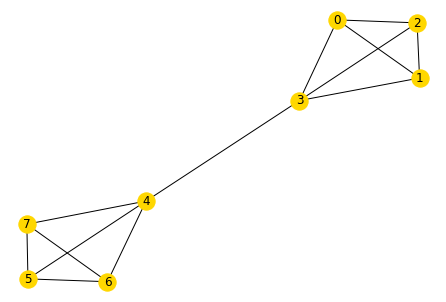

In [20]:
G = dqva.test_graph(4, 0.9)
print(list(G.edges()))
nx.draw_spring(G, with_labels=True, node_color='gold')

In [11]:
kl_bisection = ({0,1,2,3}, {4,5,6,7})
nq = len(G.nodes)
params = list(range(1, 2*nq+1+1))
print(params)
cur_init_state = '0'*nq
cur_permutation = list(range(nq))
dqv_circ = dqva.gen_dqva(G, kl_bisection, params=params, init_state=cur_init_state, cut=True,
                         mixer_order=cur_permutation, verbose=2, decompose_toffoli=2,
                         barriers=0, hot_nodes=[3])
dqv_circ.draw(fold=-1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Current partition: ({0, 1, 2, 3}, {4, 5, 6, 7})
subgraphs: [[0, 1, 2, 3], [4, 5, 6, 7]]
cutedges: [(3, 4)]
hot nodes: [3]
qubit: 0 num_qubits = 10 neighbors: [1, 2]
qubit: 1 num_qubits = 10 neighbors: [0, 3]
qubit: 2 num_qubits = 10 neighbors: [0, 3]
qubit: 3 num_qubits = 10 neighbors: [1, 2, 4]
Qubit 4 is cold! Apply Identity mixer
qubit: 5 num_qubits = 10 neighbors: [6, 7]
qubit: 6 num_qubits = 10 neighbors: [4, 5, 7]
qubit: 7 num_qubits = 10 neighbors: [4, 5, 6]
qubit: 0 num_qubits = 10 neighbors: [1, 2]
qubit: 1 num_qubits = 10 neighbors: [0, 3]
qubit: 2 num_qubits = 10 neighbors: [0, 3]
qubit: 3 num_qubits = 10 neighbors: [1, 2, 4]
Qubit 4 is cold! Apply Identity mixer
qubit: 5 num_qubits = 10 neighbors: [6, 7]
qubit: 6 num_qubits = 10 neighbors: [4, 5, 7]
qubit: 7 num_qubits = 10 neighbors: [4, 5, 6]


┌───────┐  ┌───┐                                                                                                                                                                                 ┌───┐            ┌───┐   ┌───┐                                                                                         ┌───┐      ┌───┐┌───┐                                             ┌───┐               ┌───┐┌───┐                                             ┌───┐      ┌───┐ ┌────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ┌────────┐┌───┐                                                                                                                                                                                                                                        ┌───┐               ┌───┐   ┌───┐                                                                                                         ┌───┐               ┌───┐    ┌───┐                                                                                               ┌───┐                   ┌───┐    ┌───┐                                                                                          ┌───┐             ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [18]:
cut_options = {}
cut_options['max_subcircuit_qubit'] = 9
cut_options['num_subcircuits'] = [2]
cut_options['max_cuts'] = 4
sim_with_cutting(dqv_circ, 'qasm_simulator', 15000, G, 2, mode='direct', cut_options=cut_options)

-------------------- Cut --------------------
Split circuit into 2 subcircuits with [7, 6] qubits


{'00000000': 0.0570068021822749,
 '10000000': 0.0036877961729509853,
 '00100000': 0.0043783995752506985,
 '01000000': 0.053265142146341975,
 '00000001': 0.06291001434106876,
 '10000001': 0.004750025185605593,
 '00100001': 0.00542741105737916,
 '01000001': 0.05990356415191906,
 '00010001': 0.004177696943322694,
 '00110001': 0.0021484723519026375,
 '00000010': 0.02280474274434645,
 '10000010': 0.001331207780015495,
 '00100010': 0.0015134207462708866,
 '01000010': 0.021139651791415224,
 '00000100': 0.043430560291430685,
 '10000100': 0.0026496785056568752,
 '00100100': 0.002675341508023104,
 '01000100': 0.040164731559536246,
 '00010100': 0.0009283109467157423,
 '00000110': 0.005185876740105976,
 '10000110': 9.848780354293421e-05,
 '01000110': 0.004764154755202516,
 '00001000': 0.05218751303711067,
 '10001000': 0.0023405431082770575,
 '00101000': 0.0021406635388295744,
 '01001000': 0.04821384032121109,
 '00001001': 0.24143215419801392,
 '10001001': 0.013042340049654804,
 '00101001': 0.01392

In [ ]:
cut_dqva('0'*len(G.nodes), G, m=1, threshold=1e-5, cutoff=5, sim='qasm', shots=15000, verbose=0)

In [6]:
kl = kernighan_lin_bisection(G)
print(kl)

({0, 1, 2}, {3, 4, 5})


In [9]:
cut_nodes = []
for node in kl[0]:
    for neighbor in G.neighbors(node):
        if neighbor in kl[1]:
            cut_nodes.extend([node, neighbor])
cut_nodes = list(set(cut_nodes))
print(cut_nodes)

[2, 3]


In [10]:
len({})

0

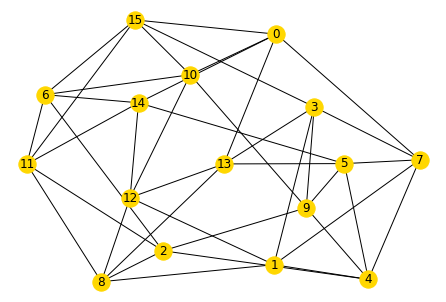

In [10]:
G = nx.random_regular_graph(5, 16)
nx.draw_spring(G, with_labels=True, node_color='gold')

# Generate cut-DQVA with updated QSPLIT

In [2]:
def apply_mixer(circ, alpha, init_state, G, cut_nodes, cutedges, subgraph_dict,
                barriers, decompose_toffoli, mixer_order, hot_nodes,
                verbose=0):
    # Pad the given alpha parameters to account for the zeroed angles
    pad_alpha = [None]*len(init_state)
    next_alpha = 0
    for qubit in mixer_order:
        bit = list(reversed(init_state))[qubit]
        if bit == '1' or next_alpha >= len(alpha) \
           or (qubit in cut_nodes and qubit not in hot_nodes):
            continue
        else:
            pad_alpha[qubit] = alpha[next_alpha]
            next_alpha += 1
    if verbose > 0:
        print('Mixer order:', mixer_order)
        print('init_state: {}, alpha: {}, pad_alpha: {}'.format(init_state,
                                                                alpha, pad_alpha))
        print('Subgraph dict:', subgraph_dict)

    # apply partial mixers V_i(alpha_i)
    # Randomly permute the order of the mixing unitaries
    if mixer_order is None:
        mixer_order = list(G.nodes)
    for qubit in mixer_order:
        if pad_alpha[qubit] == None or not G.has_node(qubit):
            # Turn off mixers for qubits which are already 1
            continue

        neighbors = list(G.neighbors(qubit))
        anc_idx = subgraph_dict[qubit]

        if verbose > 0:
            print('qubit:', qubit, 'num_qubits =', len(circ.qubits), 'neighbors:', neighbors)

        # construct a multi-controlled Toffoli gate, with open-controls on q's neighbors
        # Qiskit has bugs when attempting to simulate custom controlled gates.
        # Instead, wrap a regular toffoli with X-gates
        ctrl_qubits = [circ.qubits[i] for i in neighbors] 
        if decompose_toffoli > 0:
            # apply the multi-controlled Toffoli, targetting the ancilla qubit
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
            circ.mcx(ctrl_qubits, circ.ancillas[anc_idx])
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
        else:
            mc_toffoli = ControlledGate('mc_toffoli', len(neighbors)+1, [], num_ctrl_qubits=len(neighbors),
                                        ctrl_state='0'*len(neighbors), base_gate=XGate())
            circ.append(mc_toffoli, ctrl_qubits + [circ.ancillas[anc_idx]])

        # apply an X rotation controlled by the state of the ancilla qubit
        circ.crx(2*pad_alpha[qubit], circ.ancillas[anc_idx], circ.qubits[qubit])

        # apply the same multi-controlled Toffoli to uncompute the ancilla
        if decompose_toffoli > 0:
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
            circ.mcx(ctrl_qubits, circ.ancillas[anc_idx])
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
        else:
            circ.append(mc_toffoli, ctrl_qubits + [circ.ancillas[anc_idx]])

        if barriers > 1:
            circ.barrier()

def apply_phase_separator(circ, gamma, G):
    for qb in G.nodes:
        circ.rz(2*gamma, qb)

In [3]:
def gen_cut_dqva(G, partition, uncut_nodes, P=1, params=[], init_state=None,
                 barriers=1, decompose_toffoli=1, mixer_order=None,
                 hot_nodes=[], verbose=0):

    nq = len(G.nodes)
    subgraphs, cutedges = get_subgraphs(G, partition)

    if verbose > 0:
        print('Current partition:', partition)
        print('subgraphs:', [list(g.nodes) for g in subgraphs])
        print('cutedges:', cutedges)
        # The hot nodes parameter controls which of the nodes on the cut edges we will
        # hit with a mixer unitary. The other nodes on the cut are "cold" and their
        # mixer will be Identity
        print('hot nodes:', hot_nodes)

    # Step 1: Jump Start
    # Run an efficient classical approximation algorithm to warm-start the optimization
    # (For now, we will select the trivial set of bitstrings with Hamming weight equal to 1)
    # Each partition should get its own jump start
    if init_state is None:
        init_state = '0'*nq

    # Step 2: Mixer Initialization
    dqv_circ = QuantumCircuit(nq, name='q')

    # Add an ancilla qubit, 1 for each subgraph, for implementing the mixer unitaries
    anc_reg = AncillaRegister(len(subgraphs), 'anc')
    dqv_circ.add_register(anc_reg)

    #print('Init state:', init_state)
    for qb, bit in enumerate(reversed(init_state)):
        if bit == '1':
            dqv_circ.x(qb)
    if barriers > 0:
        dqv_circ.barrier()

    # parse the variational parameters
    cut_nodes = [n for n in G.nodes if n not in uncut_nodes]
    uncut_nonzero = len([n for n in uncut_nodes if init_state[n] != '1'])
    num_params = P * (uncut_nonzero + 1) + len(hot_nodes)
    assert (len(params) == num_params),"Incorrect number of parameters!"
    alpha_list = []
    gamma_list = []
    for p in range(P):
        chunk = uncut_nonzero + 1
        if p == 0:
            chunk += len(hot_nodes)
        cur_selection = params[p*chunk:(p+1)*chunk]
        alpha_list.append(cur_selection[:-1])
        gamma_list.append(cur_selection[-1])
        
    if verbose > 0:
        for i in range(P):
            print('alpha_{}: {}'.format(i, alpha_list[i]))
            print('gamma_{}: {}'.format(i, gamma_list[i]))
            
    subgraph_dict = {}
    for i, subgraph in enumerate(subgraphs):
        for qubit in subgraph:
            subgraph_dict[qubit] = i

    for i, (alphas, gamma) in enumerate(zip(alpha_list, gamma_list)):
        apply_mixer(dqv_circ, alphas, init_state, G, cut_nodes, cutedges,
                    subgraph_dict, barriers, decompose_toffoli, mixer_order,
                    hot_nodes, verbose=verbose)
        
        if barriers == 1:
            dqv_circ.barrier()

        apply_phase_separator(dqv_circ, gamma, G)
        
        if barriers == 0:
            dqv_circ.barrier()
            
        # in every layer of the ansatz after the first,
        # all hot nodes should be turned cold
        if i == 0:
            hot_nodes = 0

    if decompose_toffoli > 1:
        #basis_gates = ['x', 'cx', 'barrier', 'crx', 'tdg', 't', 'rz', 'h']
        basis_gates = ['x', 'h', 'cx', 'crx', 'rz', 't', 'tdg', 'u1']
        pass_ = Unroller(basis_gates)
        pm = PassManager(pass_)
        dqv_circ = pm.run(dqv_circ)

    return dqv_circ

100


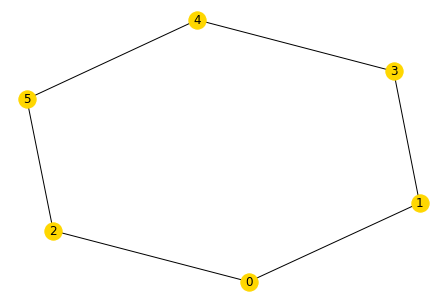

In [4]:
test_graphs = glob.glob('benchmark_graphs/N6_d2_graphs/*')
print(len(test_graphs))
test_graph = test_graphs[1]
G = graph_from_file(test_graph)
nx.draw_spring(G, with_labels=True, node_color='gold')

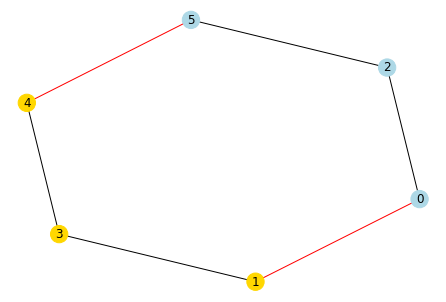

In [6]:
kl_bisection = kernighan_lin_bisection(G)
view_partition(kl_bisection, G)

In [7]:
nq = len(G.nodes())
P = 1
mixer_order = list(range(nq))
np.random.shuffle(mixer_order)

init_state = '000000'

(G_A, G_B), cutedges = get_subgraphs(G, kl_bisection)
print('G_A nodes:', G_A.nodes)
print('G_B nodes:', G_B.nodes)
print('cutedges:', cutedges)
cut_nodes = []
for edge in cutedges:
    cut_nodes.extend(edge)
cutnodes = list(set(cut_nodes))
print('cutnodes:', cut_nodes)
uncut_nodes = list(set(G.nodes).difference(set(cut_nodes)))
print('uncut nodes:', uncut_nodes)

Q_A_uc = [node for node in G_A.nodes if node in uncut_nodes]
Q_A_c = [node for node in G_A.nodes if node in cut_nodes]

Q_B_uc = [node for node in G_B.nodes if node in uncut_nodes]
Q_B_c = [node for node in G_B.nodes if node in cut_nodes]

print('Q_A_uc: {}, Q_A_c: {}'.format(Q_A_uc, Q_A_c))
print('Q_B_uc: {}, Q_B_c: {}'.format(Q_B_uc, Q_B_c))

hot_nodes = []
cut_limit = 1
cut_count = 0
starter_idx = 1
starter_graph = (G_A, G_B)[starter_idx]
starter_cut_nodes = (Q_A_c, Q_B_c)[starter_idx]
np.random.shuffle(starter_cut_nodes)
starter_cut_nodes = sorted(starter_cut_nodes,
                           key=lambda n: len((list(starter_graph.neighbors(n)))),
                           reverse=True)
print(starter_cut_nodes)
for node in starter_cut_nodes:
    t = len([e for e in cutedges if node in e])
    print('node, t:', node, t)
    if t + cut_count <= cut_limit and list(reversed(init_state))[node] != '1':
        hot_nodes.append(node)
        cut_count += t
print('hot_nodes:', hot_nodes)

uncut_nonzero = len([n for n in uncut_nodes if init_state[n] != '1'])
num_params = P * (uncut_nonzero + 1) + len(hot_nodes)

#num_nonzero = nq - hamming_weight(init_state)
#print('lim1:', P * (nq + 1))
#print('lim2:', (P+1) * (num_nonzero + 1))
#num_params = min(P * (nq + 1), (P+1) * (num_nonzero + 1))
#num_params = P * ()
params = list(range(1, num_params + 1))
print('params:', params)
print()

circ = gen_cut_dqva(G, kl_bisection, uncut_nodes, P=P, params=params,
                    init_state=init_state, barriers=2, decompose_toffoli=0,
                    mixer_order=mixer_order, hot_nodes=hot_nodes, verbose=1)
circ.draw(fold=-1)

G_A nodes: [1, 3, 4]
G_B nodes: [0, 2, 5]
cutedges: [(4, 5), (0, 1)]
cutnodes: [4, 5, 0, 1]
uncut nodes: [2, 3]
Q_A_uc: [3], Q_A_c: [1, 4]
Q_B_uc: [2], Q_B_c: [0, 5]
[5, 0]
node, t: 5 1
node, t: 0 1
hot_nodes: [5]
params: [1, 2, 3, 4]

Current partition: ({1, 3, 4}, {0, 2, 5})
subgraphs: [[1, 3, 4], [0, 2, 5]]
cutedges: [(4, 5), (0, 1)]
hot nodes: [5]
alpha_0: [1, 2, 3]
gamma_0: 4
Mixer order: [2, 0, 5, 1, 4, 3]
init_state: 000000, alpha: [1, 2, 3], pad_alpha: [None, None, 1, 3, None, 2]
Subgraph dict: {1: 0, 3: 0, 4: 0, 0: 1, 2: 1, 5: 1}
qubit: 2 num_qubits = 8 neighbors: [0, 5]
qubit: 5 num_qubits = 8 neighbors: [4, 2]
qubit: 3 num_qubits = 8 neighbors: [1, 4]


░                     ░                     ░                     ░ ┌───────┐
  q_0: ─░───o─────────────o───░─────────────────────░─────────────────────░─┤ RZ(8) ├
        ░   │             │   ░                     ░                     ░ ├───────┤
  q_1: ─░───┼─────────────┼───░─────────────────────░───o─────────────o───░─┤ RZ(8) ├
        ░   │  ┌───────┐  │   ░                     ░   │             │   ░ ├───────┤
  q_2: ─░───┼──┤ RX(2) ├──┼───░───o─────────────o───░───┼─────────────┼───░─┤ RZ(8) ├
        ░   │  └───┬───┘  │   ░   │             │   ░   │  ┌───────┐  │   ░ ├───────┤
  q_3: ─░───┼──────┼──────┼───░───┼─────────────┼───░───┼──┤ RX(6) ├──┼───░─┤ RZ(8) ├
        ░   │      │      │   ░   │             │   ░   │  └───┬───┘  │   ░ ├───────┤
  q_4: ─░───┼──────┼──────┼───░───o─────────────o───░───o──────┼──────o───░─┤ RZ(8) ├
        ░   │      │      │   ░   │  ┌───────┐  │   ░   │      │      │   ░ ├───────┤
  q_5: ─░───o──────┼──────o───░───┼──┤ RX(4) ├──┼───░───┼──────┼──────┼───░─┤ RZ(8) ├
        ░   │      │      │   ░   │  └───┬───┘  │   ░ ┌─┴─┐    │    ┌─┴─┐ ░ └───────┘
anc_0: ─░───┼──────┼──────┼───░───┼──────┼──────┼───░─┤ X ├────■────┤ X ├─░──────────
        ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ └───┘         └───┘ ░          
anc_1: ─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─────────────────────░──────────
        ░ └───┘         └───┘ ░ └───┘         └───┘ ░                     ░

In [10]:
cuts = [(circ.qubits[4], 0), (circ.qubits[4], 2)]
print('cuts:')
print(cuts)

cuts:
[(Qubit(QuantumRegister(6, 'q'), 4), 0), (Qubit(QuantumRegister(6, 'q'), 4), 2)]


In [11]:
fragments, wire_path_map = qcc.cut_circuit(circ, cuts)
fragment_cuts = ml.fragment_cuts(frag_num, wire_path_map)
for i, frag in enumerate(fragments):
    print('Fragment', i)
    print(frag)

KeyError: AncillaQubit(AncillaRegister(2, 'anc'), 1)